In [1]:
import torch
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import math

def set_training_testing(filename):
    filename_train_data = filename + '_train.data'
    x_train = (np.loadtxt(filename_train_data))
    filename_train_labels = filename + '_train.labels'
    y_train = (np.loadtxt(filename_train_labels))
    filename_test_data = filename + '_valid.data'
    x_test = (np.loadtxt(filename_test_data))
    filename_test_label = filename + '_valid.labels'
    y_test = (np.loadtxt(filename_test_label))
    x_train, x_test = standardize(x_train, x_test)
    x_train = np.nan_to_num(x_train)
    x_test = np.nan_to_num(x_test)
    return x_train, x_test, y_train, y_test
        
def standardize(x_train, x_test):
    mean, std = x_train.mean(axis=0), x_train.std(axis=0)
    x_train_norm = (x_train - mean) / std
    x_test_norm = (x_test - mean) / std
    return x_train_norm, x_test_norm

def calc_loss(x_train_tensor, y_train_tensor, weights, decay):
    a = y_train_tensor*torch.matmul(x_train_tensor, weights)
    b = torch.mean(torch.log(1+torch.clamp(1-a, min=0)**2))
    b += decay*torch.matmul(weights,weights)
    return b

def gd(x_train_tensor, y_train_tensor, iterations, lr, decay):
    weights = torch.zeros(x_train_tensor.shape[1], requires_grad=True, dtype=torch.float)
    lg = []
    for epoch in range(iterations):
        total_loss = calc_loss(x_train_tensor, y_train_tensor, weights, decay)
        total_loss.backward()
        with torch.no_grad():
            weights -= lr * weights.grad     
            weights.grad.zero_()
        running_loss = total_loss.item()
#         print('[%d] loss: %.3f' % (epoch+ 1, running_loss))
        lg.append(total_loss.item())
    return lg, weights

In [2]:
filename = 'gisette/gisette'
x_train, x_test, y_train, y_test = set_training_testing(filename)
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

C:\Users\sakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [3]:
decay = 0.0001
lr = 0.01
n_epochs = 300
lg, weight = gd(x_train_tensor, y_train_tensor, n_epochs, lr, decay)

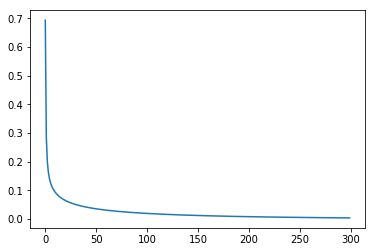

In [16]:
#part(a)
import matplotlib.pyplot as plt
plt.plot(lg)
plt.show()
#print(lg[-10:])
#print(lg[-1]- lg[-2])

For Gradient Descent, learning rate = 0.01 converges loss function between 100 and 300 iterations.


In [6]:
def newton(x_train_tensor, y_train_tensor, iterations, lr, decay, gamma):
    weights = torch.zeros(x_train_tensor.shape[1], requires_grad=True, dtype=torch.float)
    identity_torch = torch.eye(weights.shape[0])
    lg = []
    for epoch in range(iterations):
        total_loss = calc_loss(x_train_tensor, y_train_tensor, weights, decay)
        total_loss.backward()
        # Hessian for the given problem is a matrix (5000x5000) with diagnonal values 2*lambda = 2*lambda*I
        # inverse of hessian is 1/2*0.0001= 1/0.0002= 5000
        hessian = 2 * decay * identity_torch
        with torch.no_grad():
            weights -=  torch.matmul(weights.grad,torch.inverse(hessian)) * 0.33
            weights.grad.zero_()
        running_loss = total_loss.item()
        lg.append(total_loss.item())
    return lg, weights


In [7]:
decay = 0.0001
n_epochs = 31
gamma = 1
lg2, weight2 = newton(x_train_tensor, y_train_tensor, n_epochs, lr, decay, gamma)

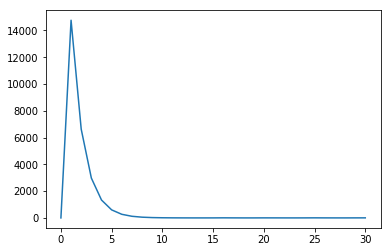

In [17]:
#part (b)
import matplotlib.pyplot as plt
plt.plot(lg2)
plt.show()

In [11]:
from scipy import optimize
t_x = np.asarray(x_train_tensor)
t_y = np.asarray(y_train_tensor)
def loss_numpy(w, x = t_x, y = t_y):
    return np.mean( np.log( 1 + np.maximum( np.zeros_like(y) , 1 - y * x.dot( w ) ) ** 2 ) ) + decay * w.dot(w) 
def grad_loss_numpy(w, x = t_x, y = t_y):
    a = 1 - y * ( x.dot( w ) )
    u = 1 +  np.maximum( np.zeros_like(y) , a ) ** 2
    dudw = 2 * ( 1 - y * x.dot( w ) ).reshape(-1, 1) * ( (-y.reshape(-1, 1)) * x )
    dudw[a<0] *= 0
    return np.mean( dudw / u.reshape(-1, 1) , axis = 0) + 2 * decay * w

w = np.zeros([5000])

Nfeval = 1
loss_bfgs = [loss_numpy(w)]

def callbackF(wi):
    global Nfeval
    global loss_bfgs
    loss = loss_numpy(wi)
    #print("'{0:4d}  {1: 3.6f}  {2: 3.6f}  {3: 3.6f}".format(Nfeval, wi[0], wi[1], loss))
    Nfeval += 1
    loss_bfgs.append(loss)

#print("{0:4s}   {1:9s}   {2:9s}  {3:9s}".format('Iter', ' w1', ' w2', 'loss'))

[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = \
    optimize.fmin_bfgs(loss_numpy,
              w,
              fprime = grad_loss_numpy,
              callback=callbackF,
              maxiter=31,
              full_output=True,
              retall=False)

         Current function value: 0.000319
         Iterations: 31
         Function evaluations: 43
         Gradient evaluations: 43


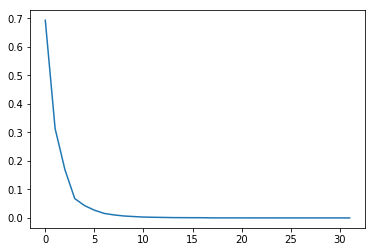

In [18]:
# part(c)
import matplotlib.pyplot as plt
plt.plot(loss_bfgs)
plt.show()

In [13]:
w = np.zeros([5000])
Nfeval = 1
loss_l_bfgs_b = [loss_numpy(w)]
def callbackF(wi):
    global Nfeval
    global loss_l_bfgs_b
    loss = loss_numpy(wi)
    print("'{0:4d} {1: 3.6f} {2: 3.6f} {3: 3.6f}".format(Nfeval, wi[0],wi[1], loss))
    Nfeval += 1
    loss_l_bfgs_b.append(loss)
print("{0:4s} {1:9s} {2:9s} {3:9s}".format('Iter', ' w1', ' w2', 'loss'))
out = optimize.fmin_l_bfgs_b(loss_numpy,
                    w,
                    fprime = grad_loss_numpy,
                    callback=callbackF,
                    maxiter=31)

Iter  w1        w2       loss     
'   1 -0.000413 -0.000506  0.312168
'   2 -0.000147  0.000062  0.229086
'   3 -0.001221  0.000859  0.093993
'   4 -0.001433  0.002687  0.062145
'   5 -0.001854  0.006475  0.039324
'   6 -0.001670  0.011306  0.022656
'   7 -0.001496  0.017056  0.013360
'   8 -0.002385  0.020003  0.008451
'   9 -0.003841  0.022132  0.005481
'  10 -0.005861  0.024398  0.003603
'  11 -0.006599  0.023391  0.002304
'  12 -0.007263  0.023434  0.001731
'  13 -0.007800  0.023398  0.001125
'  14 -0.007313  0.024875  0.000854
'  15 -0.006858  0.024982  0.000663
'  16 -0.006232  0.026074  0.000355
'  17 -0.005826  0.025681  0.000321
'  18 -0.005875  0.025377  0.000318
'  19 -0.005975  0.023414  0.000289
'  20 -0.005970  0.023151  0.000287
'  21 -0.005930  0.022259  0.000277
'  22 -0.005849  0.021800  0.000269
'  23 -0.005754  0.021020  0.000260
'  24 -0.005464  0.019266  0.000246
'  25 -0.005419  0.019023  0.000244
'  26 -0.005216  0.018259  0.000234
'  27 -0.005096  0.018138  0.

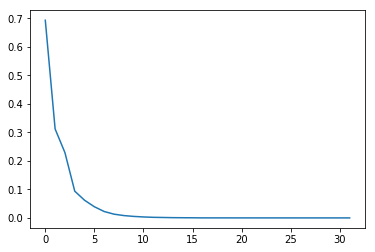

In [19]:
# part(d)
import matplotlib.pyplot as plt
plt.plot(loss_l_bfgs_b)
plt.show()

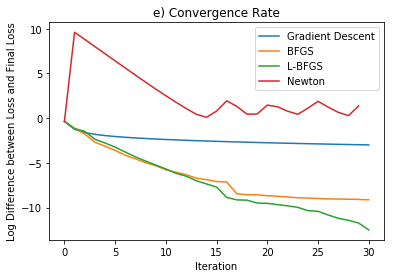

In [20]:
# part(e)
import matplotlib.pyplot as plt
min_low = min(lg[-1], lg2[-1], loss_l_bfgs_b[-1], loss_bfgs[-1], )
loss_g = [l for l in lg[:32]]
plt.plot(range(len(loss_g) - 1), [np.log(x - min_low + 1e-13) for x in loss_g[:-1]], label='Gradient Descent')
plt.plot(range(len(loss_bfgs) - 1), [np.log(x - min_low + 1e-13) for x in loss_bfgs[:-1]], label='BFGS')
plt.plot(range(len(loss_l_bfgs_b) - 1), [np.log(x - min_low + 1e-13) for x in loss_l_bfgs_b[:-1]], label='L-BFGS')
plt.plot(range(len(lg2) - 1), [np.log(x - min_low + 1e-13) for x in lg2[:-1]], label='Newton')
plt.xlabel('Iteration')
plt.ylabel('Log Difference between Loss and Final Loss')
plt.title('e) Convergence Rate')
plt.legend()
plt.show()